<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Kaggle Competition - Data and EDA

- using central file read from ZX github
- standardized variable names

## Problem Statement

## Executive Summary

## Data Dictionary

## File imports

In [1]:
#standard Imports
import pandas as pd
#so that pandas do not truncate the rows
pd.set_option('max_columns', 500) 
pd.set_option('max_rows', 500) 
#Set datafrome display format
pd.options.display.float_format = "{:,.3f}".format

import numpy as np

#graph imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#define the style of sns/plt
sns.set_style("whitegrid")
from matplotlib.lines import Line2D

#==== Date Time ==== 
from datetime import datetime
from datetime import timedelta

import geopy.distance

In [2]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

## Data Cleaning

In [3]:
def basic_eda(df, df_name='DATA SET DETAILS'):
    """
    Function to do display the basic eda upon reading data to:
    - find the shape (rows, cols)
    - Total observations
    - Duplicated rows if any
    - percent of the duplicated rows
    
    Takes in Arguements:
    - df - the dataframe/data set
    - df name - Name of the data set to display
    """
    print(df_name.upper())
    print('**********************************************')
    #print shape of df in rows and cols
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print('==============================================')
    
    print()
    #print info of the df
    print(f'{df_name}.info()')
    print('----------------------------------------------')
    print(df.info())
    print('==============================================')
    
    #print null columsn df
    print(f'{df_name}.null()')
    print('----------------------------------------------')
    print(f"{df.isnull().sum()}")
    print('==============================================')
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    #print(df.dtypes)
    print('**********************************************')


### Train

- Data Cleaning 
- Dropped redundant Columns (Address, Block, Street, AddressNumberAndStreet)
- Creating a new column ``closest_station`` that tracks the closer weather station (1 or 2) to the traps

In [4]:
train = pd.read_csv('https://raw.githubusercontent.com/zixinlee/GA-data-science/master/West-nile-virus/data/train.csv')

In [5]:
basic_eda(train, df_name='train.csv Data Set')

TRAIN.CSV DATA SET
**********************************************
Rows: 10506 	 Columns: 12

train.csv Data Set.info()
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 n

**Observations**
- 12 features
- 10506 observations 
- 6 numerical data (Block, Latitude, Longtitude, AddressAccuracy, NumMosquitos, WnvPresent)
- 6 object data (Date, Address, Species, Street, Trap,  AddressNumberAndStreet)
- to change date to datetime type
- no Null values observed
- There are 813 records of duplications, assuming to be due to multiple samples of 50 collected from the same trap, with same  species and Wnv status detected in the sample group

In [6]:
# make all column names lowercase
train.columns = train.columns.str.lower()

In [7]:
# ZX: alternative code to extract datetime elements from `date`

# convert `date` to datetime datatype
train['date'] = pd.to_datetime(train['date'])

# create new datetime element columns
train['year'] = train.date.dt.year
train['month'] = train.date.dt.month
train['weekofyear'] = train.date.dt.weekofyear
#train['yearmonth'] = train['year'].apply(str) + '-' + train['month'].apply(str) # ZX: not sure if relevant 
#ensure the months are in 05, 06 format
train['yearmonth'] = train['date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
train['weekday'] = train['date'].dt.weekday

C:\Users\Rachel\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


In [8]:
# drop the redundant location columns since we have `latitude` and `longitude`
train.drop(columns=['address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy'], inplace=True)

In [9]:
train.head()

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,weekday
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-05,1
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-05,1
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,1,0,2007,5,22,2007-05,1
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,1,0,2007,5,22,2007-05,1
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,4,0,2007,5,22,2007-05,1


#### New Feature: ```closest_station```

For each trap, identify the closer weather station and create a column to store the results

- Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level

- Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [10]:
train['coords'] = list(zip(train['latitude'], train['longitude']))

# create function to find the closer weather station from each trap

def closest_dist(coords):
    coords_s1 = (41.995, -87.933) # coordinates of station 1
    coords_s2 = (41.786, -87.752) # coordinates of station 2
    dist_from_s1 = geopy.distance.distance(coords_s1, coords).km
    dist_from_s2 = geopy.distance.distance(coords_s2, coords).km
    if dist_from_s1 > dist_from_s2:
        return 2
    else:
        return 1

# apply the function and create the `closest_station` column
train['closest_station'] = train['coords'].apply(closest_dist)

In [11]:
# delete the `coords` column
train.drop(columns='coords', inplace=True)

### Weather

Data Cleaning and adding new features:
- ``daytime`` - the total number of minutes from ``Sunrise`` to ``Sunset``
- ``rhumidity`` - the relative humidity based on ``dewpoint`` and ``tavg``
- ``rolltemp7``, ```rolltemp10```, ```rolltemp14``` - to get the rolling temp average for 7, 10 and 14 days  
- ``rollprec7``, ```rollprec10```, ```rollprec14``` - to get the rolling precipitation average for 7, 10 and 14 days
- ``rollrh7``, ```rollrh10```, ```rolltemp14``` - to get the rolling relative hudmidity average for 7, 10 and 14 days

In [12]:
weather = pd.read_csv('https://raw.githubusercontent.com/zixinlee/GA-data-science/master/West-nile-virus/data/weather.csv')


In [13]:
basic_eda(weather, df_name='weather.csv DETAILS')

WEATHER.CSV DETAILS
**********************************************
Rows: 2944 	 Columns: 22

weather.csv DETAILS.info()
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFal

**Observations**
* 22 features
* 2944 observations 
* 6 numerical data (Station Tmax, Tmin, Dewpoint, ResultSpeed, ResultDir)
* 16 object data
* initial check all object type should be numerical. TO investigate further 
* To change date column to datetime type
* no Null values observed. 
* no duplicated rows
* All empty values are filled with ``'M'`` or ``'-'``. To convert and check

**Notes:**

- **Tavg** 
   - the mean of Tmax & Tmin, to impute
   
- **Depart**
   - Temperature - fill the Depart 'M' values with NAN, fill in the the difference in Tavg and Depart of Station 1, convert to float

- **DewPoint**
  - dew point is the temperature to which air must be cooled to become saturated with water vapor -> achieve relative humidity Humidity: Relative humidity is important to mosquito activity. In general, high humidity conditions favor mosquito activity, while low humidity suppresses activity and may even cause mortality.
  - No missing values

- **WetBulb**
  - 4 missing values of wet bulb - The values for Station 1 or 2 is the same or diff by 1. We can impute using the same value as the other station

- **Heat, Cool:** 
  - Degree days are the difference between the daily temperature mean, (high temperature plus low temperature divided by two) and 65°F. If the temperature mean is above 65°F, we subtract 65 from the mean and the result is Cooling Degree Days. Degree days (in this context) are based on the assumption that when the outside temperature is 65°F, we don't need heating or cooling to be comfortable. THis is typically used for energy consumption
(https://www.weather.gov/key/climate_heat_cool). 
  - IN this instance Heat, Cool are not relevant in our findings, hence will drop

- **Sunrise and Sunset** 
   - Timing -> use ths value to calculate daytime in minutes, then drop

- **Codesum** 
   - indicates weather Phenomena which includes rain, storm etc -> can be deduce from PrecipTotal -> will drop

- **Depth, Water1, Snowfall** 
   - are not detected for all values in the sampling periods -> will not have a significance -> will drop

- **PrecipTotal** has Values M and T 
  - T -  trace denotes an amount of precipitation, such as rain or snow, that is greater than zero, but is too small to be measured by standard units or methods of measurement (<0.005). The designation of a trace rather than zero is used to indicate that precipitation did fall, but not enough to be measured reliably.  (https://www.thoughtco.com/what-is-trace-of-precipitation-3444238)
  - Will impute both T and M values to 0.001

- **StnPressure** 
  - Not relevant. To drop
  
- **SeaLevel**  
  - Not relevant. To drop

- **AvgSpeed**
  - 3 missing values (M) 
  - We can impute using the same value as the other station

In [14]:
# make all column names lowercase
weather.columns = weather.columns.str.lower()

In [15]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.700,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.700,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.000,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.300,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.700,7,11.9


**Imputing Values (for records with M or T)**

In [16]:
weather['date'] = pd.to_datetime(weather['date'])

In [17]:
# there are missing values in `tavg` so we will use `tmin` and `tmax` to calculate average temp
weather['tavg'] = (weather.tmin + weather.tmax) / 2


In [18]:
# use values from the other station to impute missing values for `depart`
for k,v in enumerate(weather['depart']):
    if v == 'M' and weather.loc[k, 'station'] == 1:
        weather.loc[k, 'depart'] = weather.loc[k+1, 'depart']
    if v == 'M' and weather.loc[k, 'station'] == 2:
        weather.loc[k, 'depart'] = weather.loc[k-1, 'depart']

In [19]:
weather['depart'] = pd.to_numeric(weather['depart'], errors='coerce')

In [20]:
# find any remaining rows that contain 'M'
weather[weather.apply(lambda row: row.astype(str).str.contains('M').any(), axis=1)]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,66.500,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.700,27,9.2
1,2,2007-05-01,84,52,68.000,14,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.700,25,9.6
2,1,2007-05-02,59,42,50.500,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.000,4,13.4
3,2,2007-05-02,60,43,51.500,-3,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.300,2,13.4
4,1,2007-05-03,66,46,56.000,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.700,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,44.500,-4,34,42,20,0,-,-,,M,M,M,0.00,29.42,30.07,8.500,29,9.0
2940,1,2014-10-30,51,32,41.500,-4,34,40,23,0,0622,1649,,0,M,0.0,0.00,29.34,30.09,5.100,24,5.5
2941,2,2014-10-30,53,37,45.000,-4,35,42,20,0,-,-,RA,M,M,M,T,29.41,30.10,5.900,23,6.5
2942,1,2014-10-31,47,33,40.000,-6,25,33,25,0,0623,1647,RA SN,0,M,0.1,0.03,29.49,30.20,22.600,34,22.9


In [21]:
# use values from the other station to impute missing values for `wetbulb`
for k,v in enumerate(weather['wetbulb']):
    if v == 'M' and weather.loc[k, 'station'] == 1:
        weather.loc[k,'wetbulb'] = weather.loc[k+1,'wetbulb']
    if v == 'M' and weather.loc[k, 'station'] == 2:
        weather.loc[k,'wetbulb'] = weather.loc[k-1,'wetbulb']

In [22]:
weather['wetbulb'] = pd.to_numeric(weather['wetbulb'], errors='coerce')

#### New Feature: ```daytime```

In [23]:
# Impute missing values for `sunrise` and `sunset` and engineer a `daytime` feature 

# Fill missing `sunrise` values in station 2 from station 1
for k, v in enumerate(weather['sunrise']):
    if v == '-' and weather.loc[k, 'station'] == 2:
        weather.loc[k, 'sunrise'] = weather.loc[k-1, 'sunrise']

# Fill missing `sunset` in station 2 from station 1
for k, v in enumerate(weather['sunset']):
    if v == '-' and weather.loc[k, 'station'] == 2:
        weather.loc[k, 'sunset'] = weather.loc[k-1, 'sunset']
        
# convert `sunrise` to datetime format
weather['sunrise'] = pd.to_datetime(weather['sunrise'].apply(lambda x: x[:2] + ':' + x[2:] + ':00')).dt.time

# there are 3 incorrect timestamp values in `sunset`
# replace all the wrong timestamp with the correct values
weather['sunset'] = np.where(weather['sunset'] == '1860', '1900', weather['sunset'])
weather['sunset'] = np.where(weather['sunset'] == '1760', '1800', weather['sunset'])
weather['sunset'] = np.where(weather['sunset'] == '1660', '1700', weather['sunset'])

# convert `sunset` to datetime format
weather['sunset'] = pd.to_datetime(weather['sunset'].apply(lambda x: x[:2] + ':' + x[2:] + ':00')).dt.time

# create a `daytime` column
weather['daytime'] = pd.to_timedelta(weather['sunset'].astype(str)) - pd.to_timedelta(weather['sunrise'].astype(str))

# convert `daytime` to minutes
weather['daytime'] = weather['daytime'].dt.total_seconds().div(60).astype(int)


In [24]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,daytime
0,1,2007-05-01,83,50,66.500,14,51,56,0,2,04:48:00,18:49:00,,0,M,0.0,0.00,29.10,29.82,1.700,27,9.2,841
1,2,2007-05-01,84,52,68.000,14,51,57,0,3,04:48:00,18:49:00,,M,M,M,0.00,29.18,29.82,2.700,25,9.6,841
2,1,2007-05-02,59,42,50.500,-3,42,47,14,0,04:47:00,18:50:00,BR,0,M,0.0,0.00,29.38,30.09,13.000,4,13.4,843
3,2,2007-05-02,60,43,51.500,-3,42,47,13,0,04:47:00,18:50:00,BR HZ,M,M,M,0.00,29.44,30.08,13.300,2,13.4,843
4,1,2007-05-03,66,46,56.000,2,40,48,9,0,04:46:00,18:51:00,,0,M,0.0,0.00,29.39,30.12,11.700,7,11.9,845


In [25]:
# impute missing values for `preciptotal`
# check 'M' values
weather[weather['preciptotal'] == 'M']

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,daytime
117,2,2007-06-28,73,61,67.000,-5,56,61,0,2,04:19:00,19:31:00,,M,M,M,M,29.43,30.07,12.200,2,13.3,912
119,2,2007-06-29,71,56,63.500,-8,56,60,1,0,04:19:00,19:31:00,,M,M,M,M,29.47,30.11,7.400,2,8.2,912


In [26]:
# the 2 missing values are from station 2
# so we will impute 'M' with values from station 1
for k,v in enumerate(weather['preciptotal']):
    if v == 'M':
        weather.loc[k,'preciptotal'] = weather.loc[k-1,'preciptotal']

In [27]:
# replace trace amounts of precipitation(https://www.thoughtco.com/what-is-trace-of-precipitation-3444238) with 0.001
weather['preciptotal'] = np.where(weather['preciptotal'] == '  T', '0.001', weather['preciptotal'])

In [28]:
weather['preciptotal'] = pd.to_numeric(weather['preciptotal'], errors='coerce')

In [29]:
# use values from the other station to impute missing values for `avgspeed`
for k,v in enumerate(weather['avgspeed']):
    if v == 'M' and weather.loc[k, 'station'] == 1:
        weather.loc[k, 'avgspeed'] = weather.loc[k+1, 'avgspeed']
    if v == 'M' and weather.loc[k, 'station'] == 2:
        weather.loc[k, 'avgspeed'] = weather.loc[k-1, 'avgspeed']

In [30]:
weather['avgspeed'] = pd.to_numeric(weather['avgspeed'], errors='coerce')

In [31]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,daytime
0,1,2007-05-01,83,50,66.500,14,51,56,0,2,04:48:00,18:49:00,,0,M,0.0,0.000,29.10,29.82,1.700,27,9.200,841
1,2,2007-05-01,84,52,68.000,14,51,57,0,3,04:48:00,18:49:00,,M,M,M,0.000,29.18,29.82,2.700,25,9.600,841
2,1,2007-05-02,59,42,50.500,-3,42,47,14,0,04:47:00,18:50:00,BR,0,M,0.0,0.000,29.38,30.09,13.000,4,13.400,843
3,2,2007-05-02,60,43,51.500,-3,42,47,13,0,04:47:00,18:50:00,BR HZ,M,M,M,0.000,29.44,30.08,13.300,2,13.400,843
4,1,2007-05-03,66,46,56.000,2,40,48,9,0,04:46:00,18:51:00,,0,M,0.0,0.000,29.39,30.12,11.700,7,11.900,845


#### New Feature: ```rhumidity```
Since relative humidity is a factor of mosquito growth, we create a column ```rhumidity``` using formula:
> ```100*(np.exp((17.625*dewpoint)/(243.04+dewpoint))/np.exp((17.625*Temp)/(243.04+Temp)))```

In [32]:
#To Create a new column 'rhumidity' for relative humidity
#A function to calculate relative humidity
def cal_rH(temp):
    """
    Function converts temp(in deg F to Deg C) to calculate the relatve humidity using formula
    -  100*(np.exp((17.625*dewpoint)/(243.04+dewpoint))/np.exp((17.625*Temp)/(243.04+Temp)))
    
    Reference:
    https://bmcnoldy.rsmas.miami.edu/Humidity.html
    
    Take in arguements:
    - temp - list of dewpoint and avg temp in F
    
    returns:
    - Relative Humidity rH
    """

    #convert dewpoint to Deg C
    TD = (temp[0] - 32) * 5/9
    #convert Tavg to Deg C
    T = (temp[1] - 32) * 5/9

    rH =100*(np.exp((17.625*TD)/(243.04+TD))/np.exp((17.625*T)/(243.04+T)))
    
    return rH

In [33]:
weather['rH_temp'] = list(zip(weather['dewpoint'], weather['tavg']))

# apply the function and create the `rhumidity` column
weather['rhumidity'] = weather['rH_temp'].apply(cal_rH)

#drop after gotten the relative humidity value
weather.drop(columns='rH_temp', inplace=True)

### New Feature: Rolling averages 

For the Culex pipiens, Cx. quinquefasciatus, and Cx. tarsalis species: the life cycle of the mosquito  - 7-10 days from incubation to adult
ref: https://www.cdc.gov/westnile/resources/pdfs/FS_MosquitoLifeCycle-508.pdf

We will therefore take rollng 7, 10 and 14 days average for the 3 factors that affect the mosquito breeding:
- Temperature ```tavg``` 
- Precipitation Total ```preciptotal```
- Relative humidity ```rhumidity```


In [34]:
roll_lst = [7,10,14]

# create the running_PrecipTotal column
for item in roll_lst:
    weather['rolltemp'+str(item)] = weather['tavg'].rolling(item).mean()
    weather['rolltemp'+str(item)].fillna(value=65, inplace=True)

    weather['rollprec'+str(item)] = weather['preciptotal'].rolling(item).mean()
    weather['rollprec'+str(item)].fillna(value=0, inplace=True)

    weather['rollrh'+str(item)] = weather['rhumidity'].rolling(item).mean()
    weather['rollrh'+str(item)].fillna(value=weather['rhumidity'].mean(), inplace=True)


In [35]:
weather.head(15)

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,daytime,rhumidity,rolltemp7,rollprec7,rollrh7,rolltemp10,rollprec10,rollrh10,rolltemp14,rollprec14,rollrh14
0,1,2007-05-01,83,50,66.500,14,51,56,0,2,04:48:00,18:49:00,,0,M,0.0,0.000,29.10,29.82,1.700,27,9.200,841,57.423,65.000,0.000,62.811,65.000,0.000,62.811,65.000,0.000,62.811
1,2,2007-05-01,84,52,68.000,14,51,57,0,3,04:48:00,18:49:00,,M,M,M,0.000,29.18,29.82,2.700,25,9.600,841,54.526,65.000,0.000,62.811,65.000,0.000,62.811,65.000,0.000,62.811
2,1,2007-05-02,59,42,50.500,-3,42,47,14,0,04:47:00,18:50:00,BR,0,M,0.0,0.000,29.38,30.09,13.000,4,13.400,843,72.527,65.000,0.000,62.811,65.000,0.000,62.811,65.000,0.000,62.811
3,2,2007-05-02,60,43,51.500,-3,42,47,13,0,04:47:00,18:50:00,BR HZ,M,M,M,0.000,29.44,30.08,13.300,2,13.400,843,69.892,65.000,0.000,62.811,65.000,0.000,62.811,65.000,0.000,62.811
4,1,2007-05-03,66,46,56.000,2,40,48,9,0,04:46:00,18:51:00,,0,M,0.0,0.000,29.39,30.12,11.700,7,11.900,845,54.875,65.000,0.000,62.811,65.000,0.000,62.811,65.000,0.000,62.811
5,2,2007-05-03,67,48,57.500,2,40,50,7,0,04:46:00,18:51:00,HZ,M,M,M,0.000,29.46,30.12,12.900,6,13.200,845,51.983,65.000,0.000,62.811,65.000,0.000,62.811,65.000,0.000,62.811
6,1,2007-05-04,66,49,57.500,4,41,50,7,0,04:44:00,18:52:00,RA,0,M,0.0,0.001,29.31,30.05,10.400,8,10.800,848,54.038,58.214,0.000,59.323,65.000,0.000,62.811,65.000,0.000,62.811
7,2,2007-05-04,78,51,64.500,4,42,50,M,M,04:44:00,18:52:00,,M,M,M,0.000,29.36,30.04,10.100,7,10.400,848,43.826,57.929,0.000,57.381,65.000,0.000,62.811,65.000,0.000,62.811
8,1,2007-05-05,66,53,59.500,5,38,49,5,0,04:43:00,18:53:00,,0,M,0.0,0.001,29.40,30.10,11.700,7,12.000,850,44.756,56.714,0.000,55.985,65.000,0.000,62.811,65.000,0.000,62.811
9,2,2007-05-05,66,54,60.000,5,39,50,5,0,04:43:00,18:53:00,,M,M,M,0.001,29.46,30.09,11.200,7,11.500,850,45.720,58.071,0.000,52.156,59.150,0.000,54.957,65.000,0.000,62.811


In [36]:
cols_to_drop = ['sunrise','sunset', 'codesum', 'depth', 'water1', 'snowfall', 'stnpressure', 'sealevel', 'heat', 'cool']
weather.drop(columns=cols_to_drop, inplace=True)

In [37]:
#Finding the range of values for the weather data
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
station,"2,944.000",1.500,0.500,1.000,1.000,1.500,2.000,2.000
tmax,"2,944.000",76.166,11.462,41.000,69.000,78.000,85.000,104.000
tmin,"2,944.000",57.810,10.382,29.000,50.000,59.000,66.000,83.000
tavg,"2,944.000",66.988,10.534,35.500,60.000,68.500,75.000,93.500
depart,"2,944.000",1.954,6.840,-17.000,-3.000,2.000,7.000,23.000
dewpoint,"2,944.000",53.458,10.675,22.000,46.000,54.000,62.000,75.000
wetbulb,"2,944.000",59.319,9.284,32.000,53.000,61.000,67.000,78.000
preciptotal,"2,944.000",0.131,0.393,0.000,0.000,0.000,0.060,6.860
resultspeed,"2,944.000",6.961,3.588,0.100,4.300,6.400,9.200,24.100
resultdir,"2,944.000",17.495,10.064,1.000,7.000,19.000,25.000,36.000


In [38]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   float64       
 5   depart       2944 non-null   int64         
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2944 non-null   int64         
 8   preciptotal  2944 non-null   float64       
 9   resultspeed  2944 non-null   float64       
 10  resultdir    2944 non-null   int64         
 11  avgspeed     2944 non-null   float64       
 12  daytime      2944 non-null   int32         
 13  rhumidity    2944 non-null   float64       
 14  rolltemp7    2944 non-null   float64       
 15  rollprec7    2944 non-null   float64       
 16  rollrh

### Spray 

In [39]:
spray = pd.read_csv('https://raw.githubusercontent.com/zixinlee/GA-data-science/master/West-nile-virus/data/spray.csv')

In [40]:
basic_eda(spray, df_name='spray.csv DETAILS')

SPRAY.CSV DETAILS
**********************************************
Rows: 14835 	 Columns: 4

spray.csv DETAILS.info()
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB
None
spray.csv DETAILS.null()
----------------------------------------------
Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64
Total null rows: 584
Percentage null rows: 3.94%

Total duplicate rows: 543
Percentage dupe rows: 3.66%

**********************************************


**Observations**
- 4 features
- 14835 observations, out of which 584 are null from the Time column
- Date and Time columns to be changed to DateTime Objects

<font color = blue>The missing values are less than 5% of the total dataset. We should be able to drop these rows

In [41]:
# make all column names lowercase
spray.columns = spray.columns.str.lower()

In [42]:
spray['date'] = pd.to_datetime(spray['date'])

In [43]:
spray.dropna(axis=1, inplace=True)
spray.shape

(14835, 3)

### Combining Train and Weather Data

In [44]:
# Left join `weather` to `train` using `date` and `station` as keys
train_weather = pd.merge(train, weather, left_on=['date', 'closest_station'], right_on=['date', 'station'], how="left")

In [45]:
# create dummy variables for `species` and `trap`
#train = pd.get_dummies(data=train, columns=['species', 'trap'])

In [46]:
train_weather.shape

(10506, 35)

In [47]:
train_weather.head()

,date,species,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,weekofyear,yearmonth,weekday,closest_station,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,resultspeed,resultdir,avgspeed,daytime,rhumidity,rolltemp7,rollprec7,rollrh7,rolltemp10,rollprec10,rollrh10,rolltemp14,rollprec14,rollrh14
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-05,1,1,1,88,60,74.000,10,58,65,0.000,5.800,18,6.500,896,57.398,64.786,0.202,63.692,65.500,0.150,59.577,68.286,0.109,53.840
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,1,0,2007,5,22,2007-05,1,1,1,88,60,74.000,10,58,65,0.000,5.800,18,6.500,896,57.398,64.786,0.202,63.692,65.500,0.150,59.577,68.286,0.109,53.840
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,1,0,2007,5,22,2007-05,1,1,1,88,60,74.000,10,58,65,0.000,5.800,18,6.500,896,57.398,64.786,0.202,63.692,65.500,0.150,59.577,68.286,0.109,53.840
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,1,0,2007,5,22,2007-05,1,1,1,88,60,74.000,10,58,65,0.000,5.800,18,6.500,896,57.398,64.786,0.202,63.692,65.500,0.150,59.577,68.286,0.109,53.840
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,4,0,2007,5,22,2007-05,1,1,1,88,60,74.000,10,58,65,0.000,5.800,18,6.500,896,57.398,64.786,0.202,63.692,65.500,0.150,59.577,68.286,0.109,53.840


## EDA

### Train Data

- Range from May 2007 to Sep 2013
- Data only available for 2007, 2009, 2011 and 2013

#### Total Sample records across Year, Month

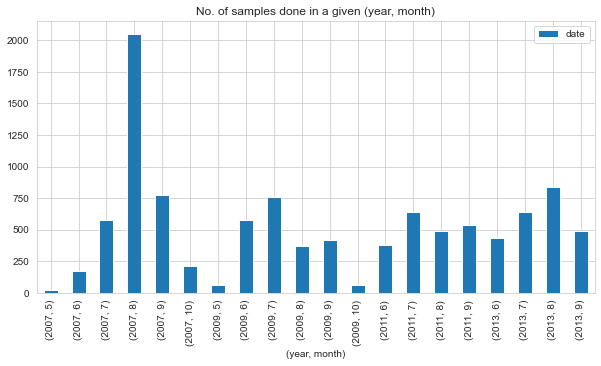

In [48]:
ax = pd.DataFrame(train.groupby([train['year'], train['month']]).count()['date']).plot(kind='bar', figsize=(10,5))
ax.set_xlabel('(year, month)')
ax.set_title('No. of samples done in a given (year, month)');

<font color = blue>
More sampling records are found in 2007 Aug, then by 2013 Aug
More samples are collected in the months of Jun to Sep

In [49]:
train['wnvpresent'].value_counts(normalize=True)

0   0.948
1   0.052
Name: wnvpresent, dtype: float64

<font color='blue'> Notes: Very imbalanced data

#### Samples with WMV present across Year, Month

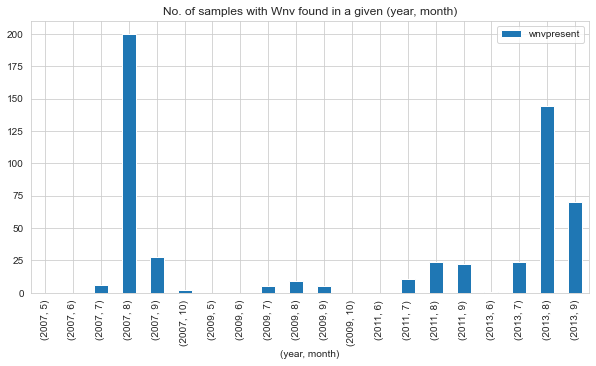

In [50]:
ax = pd.DataFrame(train.groupby([train['year'], train['month']]).sum()['wnvpresent']).plot(kind='bar', figsize=(10,5))
ax.set_xlabel('(year, month)')
ax.set_title('No. of samples with Wnv found in a given (year, month)');

<font color = blue>Highest valules in 2007 Aug and again at 2013 Aug

#### Total number of Mosquitos collected across Year, Month

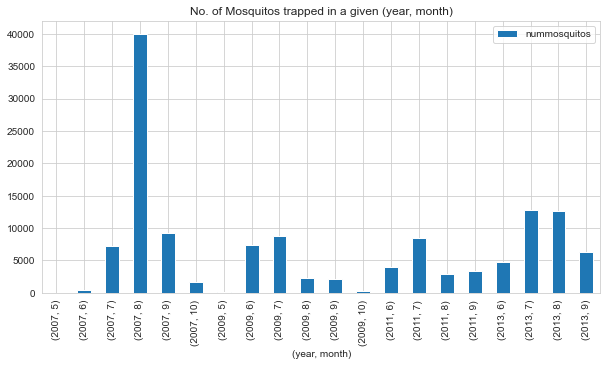

In [51]:
# See the number toal number samples across months
ax = pd.DataFrame(train.groupby([train['year'], train['month']]).sum()['nummosquitos']).plot(kind='bar', figsize=(10,5))
ax.set_xlabel('(year, month)')
ax.set_title('No. of Mosquitos trapped in a given (year, month)');

<font color = blue>Highest valules in 2007 Aug as well.

#### Mosquito Species spread

In [52]:
train['species'].value_counts(normalize=True)

CULEX PIPIENS/RESTUANS   0.452
CULEX RESTUANS           0.261
CULEX PIPIENS            0.257
CULEX TERRITANS          0.021
CULEX SALINARIUS         0.008
CULEX TARSALIS           0.001
CULEX ERRATICUS          0.000
Name: species, dtype: float64

In [53]:
df_MosWnv = pd.DataFrame(train[['species', 'nummosquitos', 'wnvpresent']].groupby(by='species').sum())
df_MosWnv

,nummosquitos,wnvpresent
species,,
CULEX ERRATICUS,7,0
CULEX PIPIENS,44671,240
CULEX PIPIENS/RESTUANS,66268,262
CULEX RESTUANS,23431,49
CULEX SALINARIUS,145,0
CULEX TARSALIS,7,0
CULEX TERRITANS,510,0


<font color=blue>
From the above data, it seemed that the wnv typically is found in the 
<li> CULEX PIPIENS (240 counts)
<li> CULEX PIPIENS/RESTUANS (262 counts)
<li> CULEX RESTUANS (49 counts)

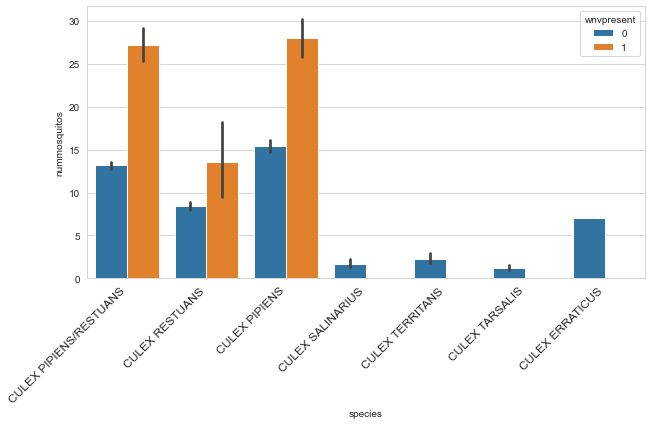

In [54]:
#plot species against WNV found
plt.figure(figsize=(10,5))

sns.barplot(x="species", y='nummosquitos', hue="wnvpresent", data=train)
plt.xticks(rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
);

<font color=blue>
From this graph, it could also mean that the other species don't have enough mosquito counts that might detect the virus. 
We will use this as categorical data and encode do the prediction

#### No of Traps and Wnv present

In [55]:
train['trap'].nunique()

136

<font color='blue'> There are total of 136 traps

#### Visualizing Location of Traps and presence of Wnv

No handles with labels found to put in legend.


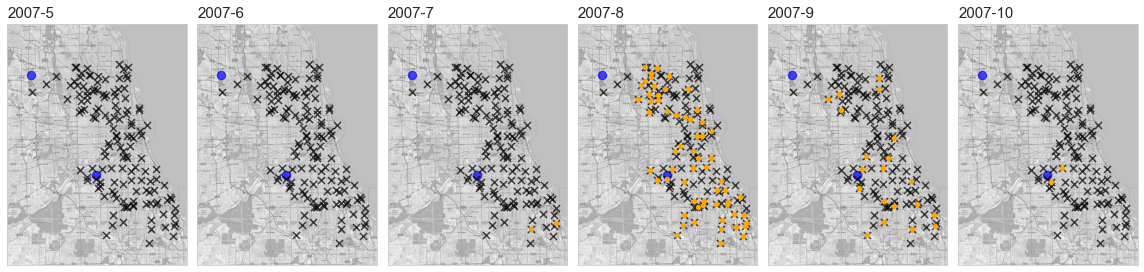

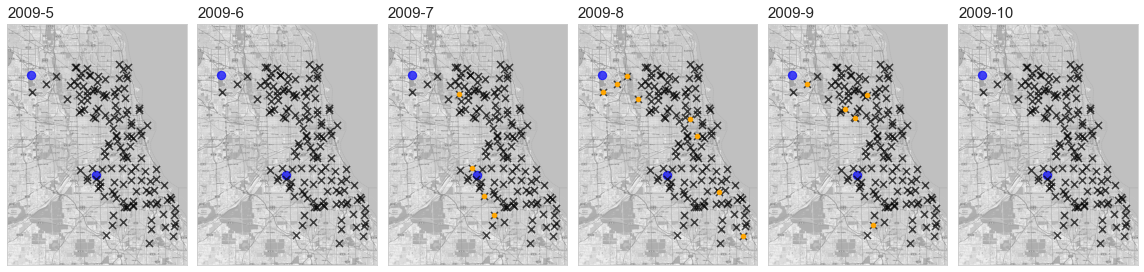

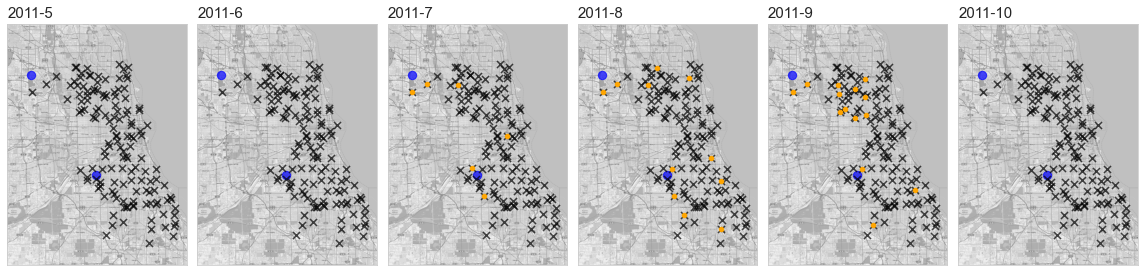

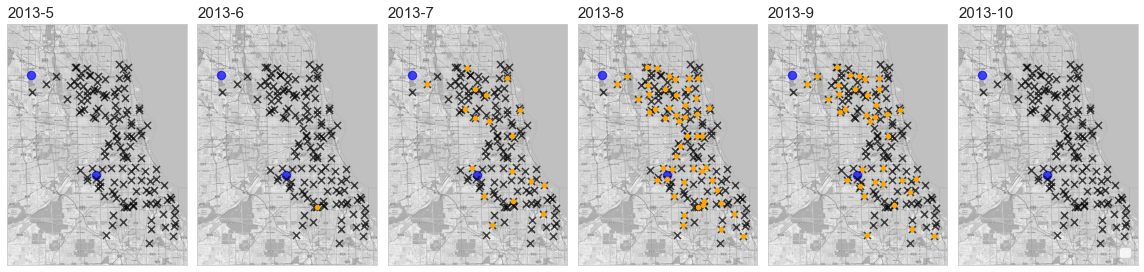

In [56]:
mapdata = np.loadtxt('https://raw.githubusercontent.com/rachellimce/DSI_Projects/master/project_4/datasets/mapdata_copyright_openstreetmap_contributors.txt')
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# create plot for each month and year 
#loop year
for year in train['date'].dt.year.unique():
    fig, ax = plt.subplots(ncols = 6, figsize = (16,5))
    
    #loop month
    for i, month in enumerate(train['date'].dt.month.unique()):
        # plot basemap
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
        
        ## plot station locations
        station = np.array([[-87.933, 41.995], [-87.752, 41.786]])
        ax[i].scatter(station[:,0], station[:,1], marker='o', c = 'blue', s=70, alpha = 0.7)
        
        # plot trap locations
        locations = train[['longitude', 'latitude']].drop_duplicates().values
        ax[i].scatter(locations[:,0], locations[:,1], marker='x', c = 'black', s=50, alpha = 0.7)
        
        # plot wnv locations
        wnv = train[(train['date'].dt.year == year) & (train['date'].dt.month == month) & (train['wnvpresent'] == 1)]\
                [['longitude', 'latitude']].drop_duplicates().values
        
        ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'orange', s =20)
        
        # title and axes
        ax[i].set_title(f"{year}-{month}", fontsize = 15, ha = 'left', position = (0,1))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        plt.tight_layout()
#         plt.savefig(f'heatmap_{year}_{month}')


plt.legend(loc='lower right', fontsize=14)
plt.tight_layout()

In [57]:
df_TrapMosWnv = pd.DataFrame(train[['trap', 'nummosquitos', 'wnvpresent']].groupby(by='trap').sum().sort_values(by='wnvpresent', ascending=False))

#show the top 10 traps that had the most number of wnv cases detected
df_TrapMosWnv.head(10)

,nummosquitos,wnvpresent
trap,,
T900,15386,66
T115,21668,41
T002,3710,18
T138,9936,16
T003,1346,14
T011,1311,11
T225,2014,11
T128,3315,11
T903,2327,10


<font color=blue>
<li>T900 has the highest number of total mosquitos trapped and highest number of Wnv detected, followed by T115.
<li>T002 has much lesser mosquitos collected (62% lesser) compared to T138 but higher occurance of wnv.
<li>T003 has only 1346 mosquitos collected but 14 occurances observed
<li>We investigate these top 5 locations for further analysis. 

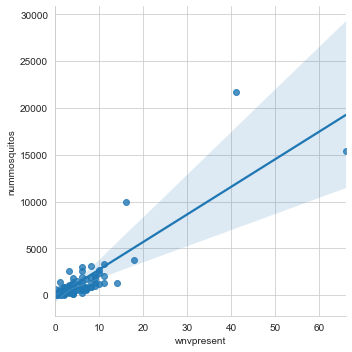

In [58]:
sns.lmplot(x='wnvpresent', y='nummosquitos', data=df_TrapMosWnv)

No handles with labels found to put in legend.


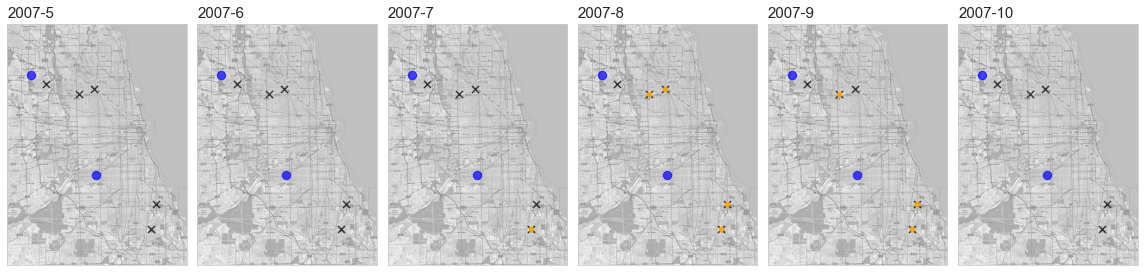

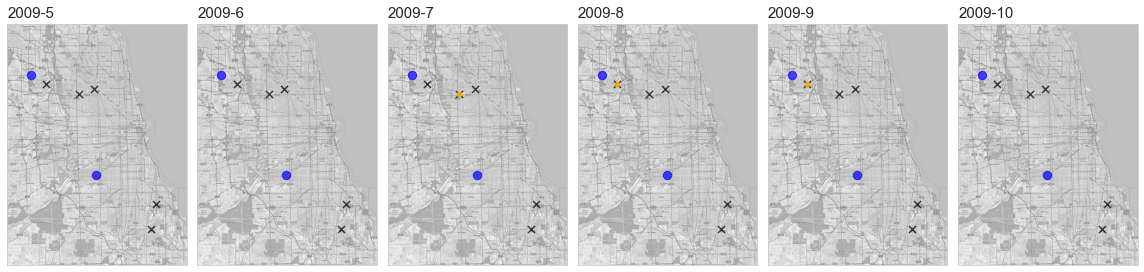

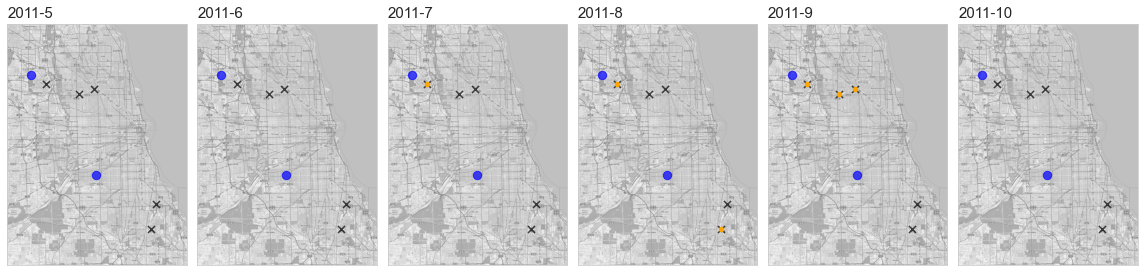

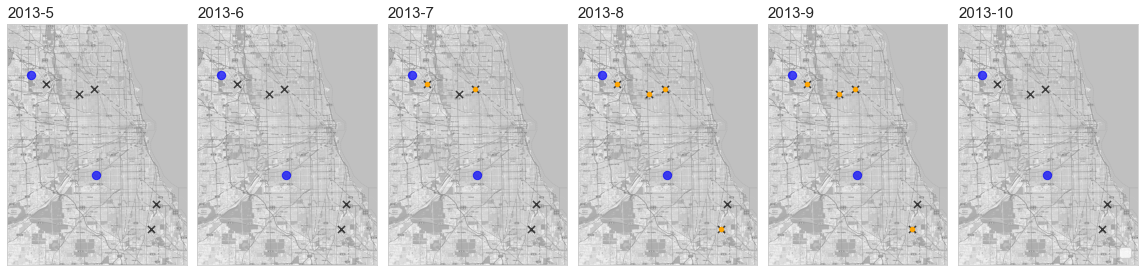

In [59]:
lst_traps = ['T900', 'T115', 'T002', 'T138', 'T003']

for year in train['date'].dt.year.unique():
    fig, ax = plt.subplots(ncols = 6, figsize = (16,5))
    
    #loop month
    for i, month in enumerate(train['date'].dt.month.unique()):
        # plot basemap
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
        
        ## plot station locations
        station = np.array([[-87.933, 41.995], [-87.752, 41.786]])
        ax[i].scatter(station[:,0], station[:,1], marker='o', c = 'blue', s=70, alpha = 0.7)
        
        # plot trap locations
        locations = train[train['trap'].isin(lst_traps)][['longitude', 'latitude']].drop_duplicates().values
        ax[i].scatter(locations[:,0], locations[:,1], marker='x', c = 'black', s=50, alpha = 0.7)
        
        # plot wnv locations
        wnv = train[(train['trap'].isin(lst_traps)) & (train['date'].dt.year == year) & (train['date'].dt.month == month) & (train['wnvpresent'] == 1)]\
                [['longitude', 'latitude']].drop_duplicates().values
        
        ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'orange', s =20)
        
        # title and axes
        ax[i].set_title(f"{year}-{month}", fontsize = 15, ha = 'left', position = (0,1))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        plt.tight_layout()
#         plt.savefig(f'heatmap_{year}_{month}')


plt.legend(loc='lower right', fontsize=14)
plt.tight_layout()

In [60]:
train.columns

Index(['date', 'species', 'trap', 'latitude', 'longitude', 'nummosquitos',
       'wnvpresent', 'year', 'month', 'weekofyear', 'yearmonth', 'weekday',
       'closest_station'],
      dtype='object')

In [61]:
lst_traps = ['T900', 'T115', 'T002', 'T138', 'T003']
df_selectedtraps = train[train['trap'].isin(lst_traps)]
df_selectedtraps = pd.DataFrame(df_selectedtraps[['yearmonth', 'trap','nummosquitos']].groupby(by=['yearmonth', 'trap']).sum()).sort_values(by='yearmonth')


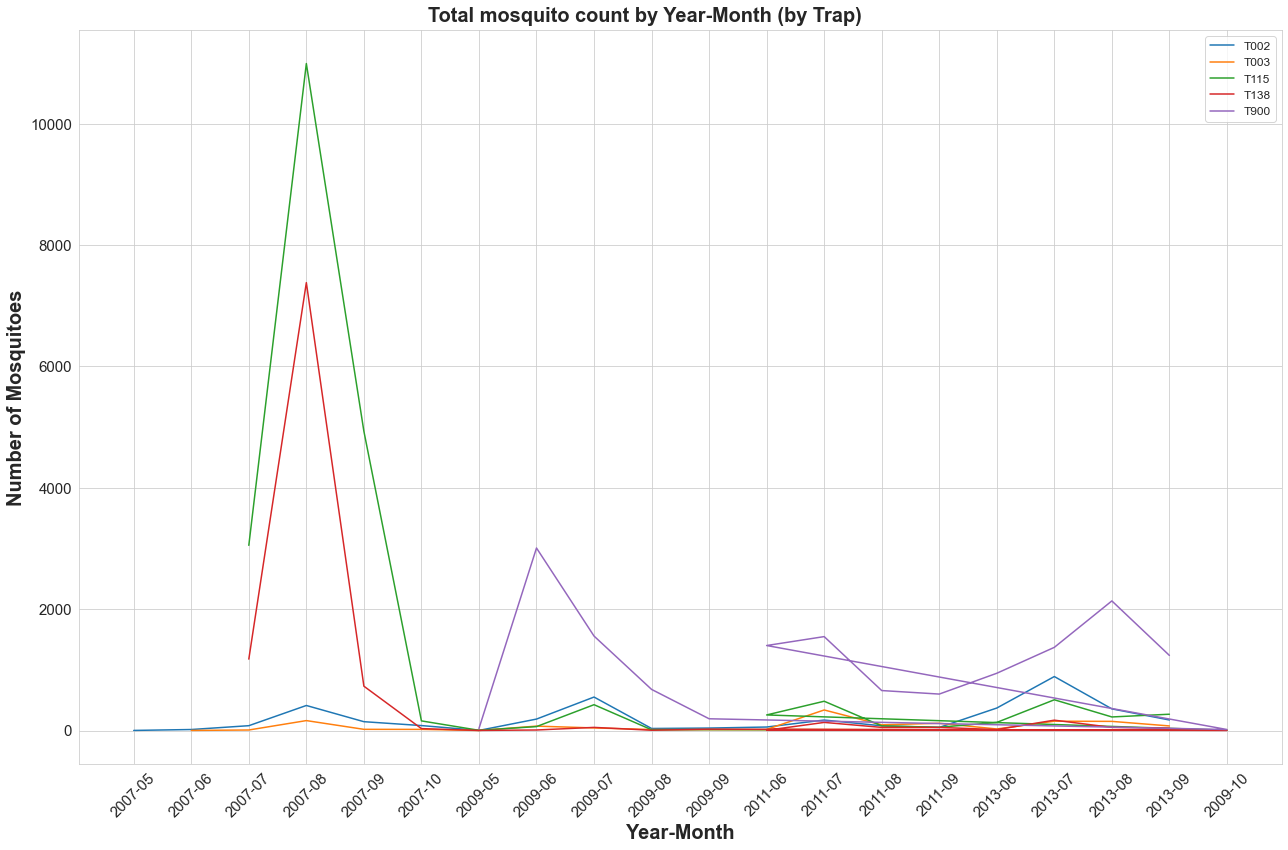

In [62]:

# since temp_df now is a multi-index df, we need to iterate through the index to pass `YearMonth` and `Species` to the plot  function
x_index = [keys for keys, values in df_selectedtraps.index]
hue_index = [values for keys, values in df_selectedtraps.index]

plt.figure(figsize=(18,12))

sns.lineplot(x = x_index,y = "nummosquitos", data =df_selectedtraps,hue=hue_index)

plt.xlabel('Year-Month', fontweight='bold', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=45)

title = "Total mosquito count by Year-Month (by Trap)"
plt.suptitle(title, fontweight='bold', fontsize='20', horizontalalignment='center')

plt.legend(fontsize='large', title_fontsize='20')


plt.tight_layout()

plt.savefig(title)

#### Counting total Mosquito in a Trap

As the test results are organized in a way that the number of mosquitoes are capped at 50 for each record even when the samples are collected on the same day. We will combine these records into a single record, track the total number of mosquito collected, and how many records were collected

In [63]:
total_mosq = train[['date', 'species', 'trap', 'nummosquitos', 'wnvpresent']]\
    .groupby(['date', 'species', 'trap'])\
        .agg(row_count=('trap', 'count'),
             mosquito_count=('nummosquitos', 'sum'), 
             wnv_count=('wnvpresent', 'sum')).reset_index().sort_values('row_count')

total_mosq['wnvpresent'] = total_mosq['wnv_count'].map(lambda x : 1 if x > 0 else x)

In [64]:
total_mosq.shape

(8475, 7)

In [65]:
total_mosq.sort_values(by='wnv_count', ascending=False)

,date,species,trap,row_count,mosquito_count,wnv_count,wnvpresent
1450,2007-08-16,CULEX PIPIENS,T115,51,2532,10,1
7428,2013-08-01,CULEX PIPIENS/RESTUANS,T900,25,984,9,1
7971,2013-08-29,CULEX PIPIENS,T900,10,281,8,1
1666,2007-08-22,CULEX PIPIENS,T115,32,1554,7,1
1669,2007-08-22,CULEX PIPIENS,T138,22,1054,6,1
...,...,...,...,...,...,...,...
7957,2013-08-29,CULEX PIPIENS,T138,1,9,0,0
7958,2013-08-29,CULEX PIPIENS,T145,1,13,0,0
7959,2013-08-29,CULEX PIPIENS,T151,1,17,0,0
7996,2013-08-29,CULEX PIPIENS/RESTUANS,T074,1,8,0,0


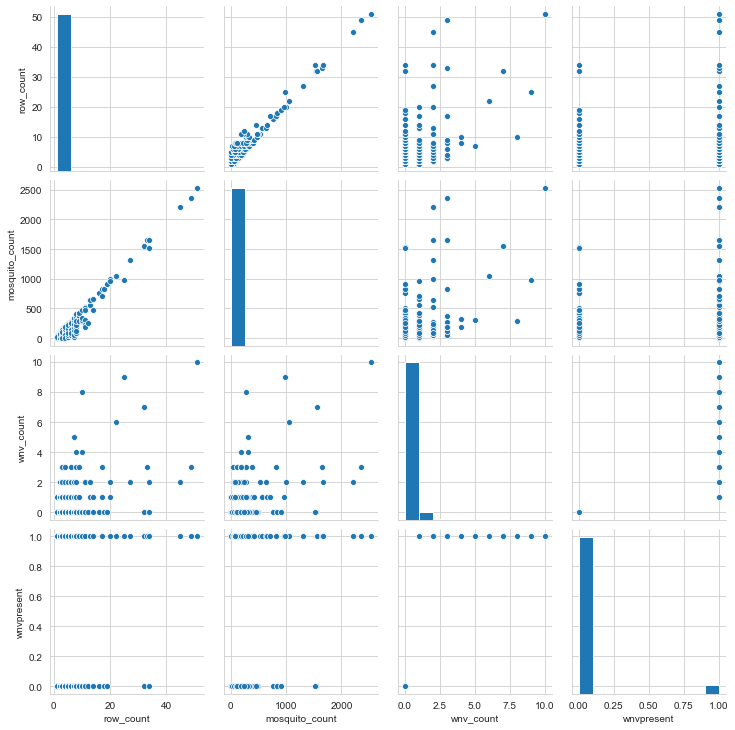

In [66]:
sns.pairplot(total_mosq)

<font color=blue> row_count has a linear relation with mosquito count. We may be able to use this row to impute Num of Mosquitos which will be missing from test data

### Weather data

- Range from May 2007 to Oct 2014
- Data is collected from 2 different stations

In [67]:
weather.columns

Index(['station', 'date', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'preciptotal', 'resultspeed', 'resultdir', 'avgspeed',
       'daytime', 'rhumidity', 'rolltemp7', 'rollprec7', 'rollrh7',
       'rolltemp10', 'rollprec10', 'rollrh10', 'rolltemp14', 'rollprec14',
       'rollrh14'],
      dtype='object')

#### Average Temperature Across Year

(5.0, 10.0)

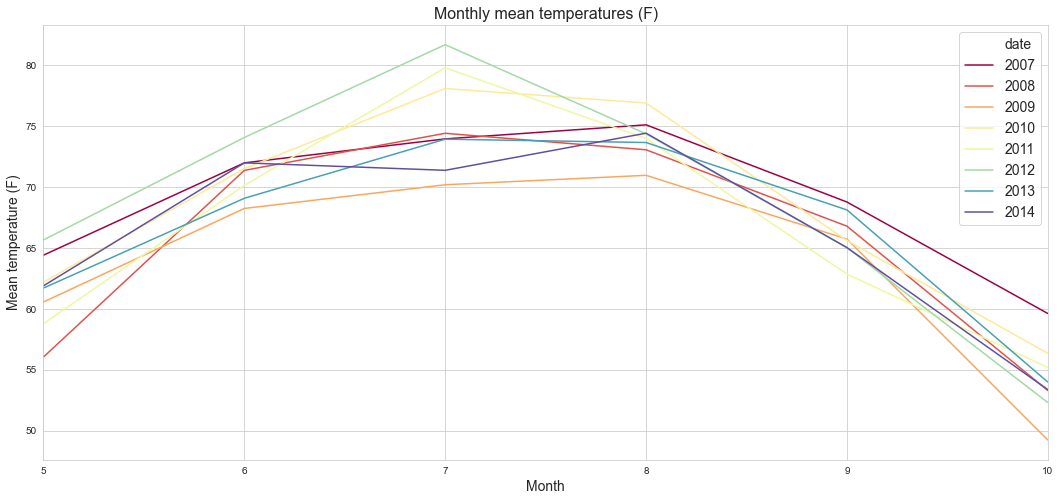

In [68]:
plt.figure(figsize=(18,8))
sns.lineplot(x = weather['date'].dt.month, y = 'tavg', data = weather, 
             hue = weather['date'].dt.year, ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean temperatures (F)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean temperature (F)',fontsize=14)
plt.xlim(weather['date'].dt.month.unique().min(), weather['date'].dt.month.unique().max())


<font color=blue> 
Temperature shows similar trends of reaching the highest (to about 70 F) in Aug every year except for 2010 to 2012, where the temperature peaks at July instead. 
We also see a climb in Mosquito collection and Wnv detection during July/Aug months for 2007 and 2013 

#### Average Rainfall Across Year

(5.0, 10.0)

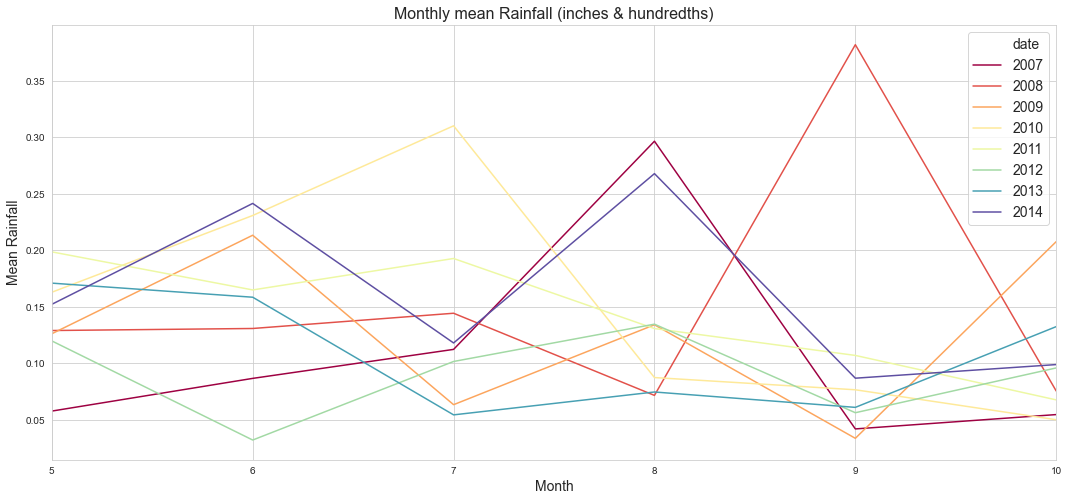

In [69]:
plt.figure(figsize=(18,8))
sns.lineplot(x = weather['date'].dt.month, y = 'preciptotal', data = weather, 
             hue = weather['date'].dt.year, ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean Rainfall (inches & hundredths)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean Rainfall',fontsize=14)
plt.xlim(weather['date'].dt.month.unique().min(), weather['date'].dt.month.unique().max())


<font color=blue>
No specific pattern in the average amount of rainfall as it varies from year to year. 2007 has a higher rainfall in Aug (which has higher Wnv detection rate), but we don't see the same trend for 2013 
There is also higher than normal amounts of rain in Sept 2009.
    

#### Average Relative Humidity Across Year

(5.0, 10.0)

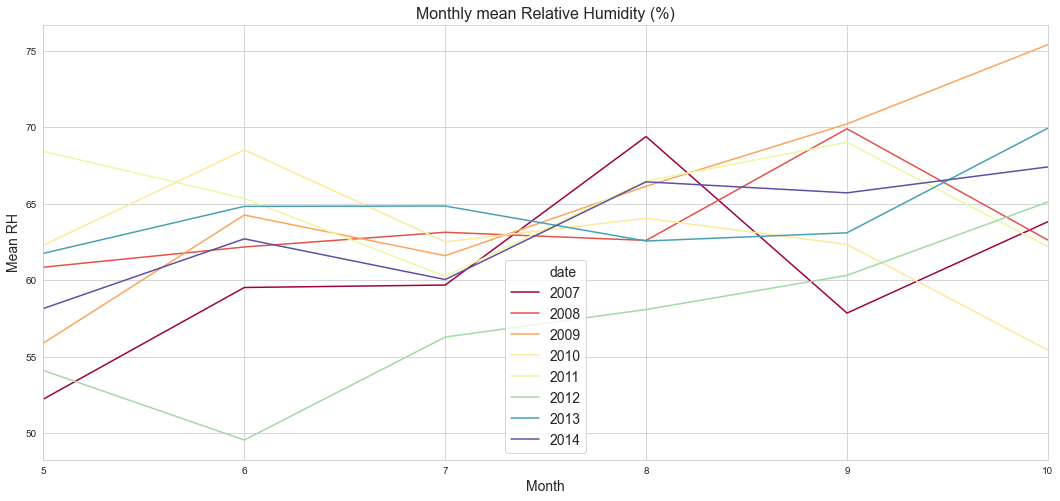

In [70]:
plt.figure(figsize=(18,8))
sns.lineplot(x = weather['date'].dt.month, y = 'rhumidity', data = weather, 
             hue = weather['date'].dt.year, ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean Relative Humidity (%)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean RH',fontsize=14)
plt.xlim(weather['date'].dt.month.unique().min(), weather['date'].dt.month.unique().max())


<font color=blue>
As with Rainfall, no specific pattern in the average relative humidity as well with the different year on year variations. 
2007 seemed to have the higher 
    

### Spray data

- Range from Aug 2011 to Sep 2013
- There is no data for 2008 to 2010 and no data for 2012, 2014. 

In [71]:
spray.columns

Index(['date', 'latitude', 'longitude'], dtype='object')

In [72]:
# creating a set of unique spray dates
unique_spray_dates = set (spray["date"].unique())
unique_spray_dates

{numpy.datetime64('2011-08-29T00:00:00.000000000'),
 numpy.datetime64('2011-09-07T00:00:00.000000000'),
 numpy.datetime64('2013-07-17T00:00:00.000000000'),
 numpy.datetime64('2013-07-25T00:00:00.000000000'),
 numpy.datetime64('2013-08-08T00:00:00.000000000'),
 numpy.datetime64('2013-08-15T00:00:00.000000000'),
 numpy.datetime64('2013-08-16T00:00:00.000000000'),
 numpy.datetime64('2013-08-22T00:00:00.000000000'),
 numpy.datetime64('2013-08-29T00:00:00.000000000'),
 numpy.datetime64('2013-09-05T00:00:00.000000000')}

<font color='blue'>
    Since there is no spray data for 2008 to 2010 and no data for 2012, 2014, we are not able to use data from this set as features to predict for 2008, 2010, 2012 and 2014 data. We will ignore spray data for now

### Finding Correlation between the features in train and weather and presence of Wnv

In [73]:
train_weather.columns

Index(['date', 'species', 'trap', 'latitude', 'longitude', 'nummosquitos',
       'wnvpresent', 'year', 'month', 'weekofyear', 'yearmonth', 'weekday',
       'closest_station', 'station', 'tmax', 'tmin', 'tavg', 'depart',
       'dewpoint', 'wetbulb', 'preciptotal', 'resultspeed', 'resultdir',
       'avgspeed', 'daytime', 'rhumidity', 'rolltemp7', 'rollprec7', 'rollrh7',
       'rolltemp10', 'rollprec10', 'rollrh10', 'rolltemp14', 'rollprec14',
       'rollrh14'],
      dtype='object')

In [74]:
#drop the non numeric and related columns
trw_corr = train_weather.drop(columns=['date', 'species', 'trap','closest_station', 'station', 'weekday', 'yearmonth', 'tmin', 'tmax'])
trw_corr.corr()['wnvpresent'].sort_values(ascending=False)

wnvpresent      1.000
nummosquitos    0.197
weekofyear      0.104
month           0.100
rollrh10        0.092
rollrh14        0.087
dewpoint        0.085
rollrh7         0.082
wetbulb         0.079
rolltemp7       0.069
tavg            0.059
rhumidity       0.058
rolltemp14      0.057
rolltemp10      0.056
depart          0.055
year            0.051
rollprec14      0.046
rollprec10      0.036
rollprec7       0.033
latitude        0.029
preciptotal     0.021
resultdir      -0.001
avgspeed       -0.032
resultspeed    -0.045
longitude      -0.060
daytime        -0.080
Name: wnvpresent, dtype: float64

<font color=blue> It seemed like numofmosquitos has the highest relation, followed by weekofyear

<AxesSubplot:>

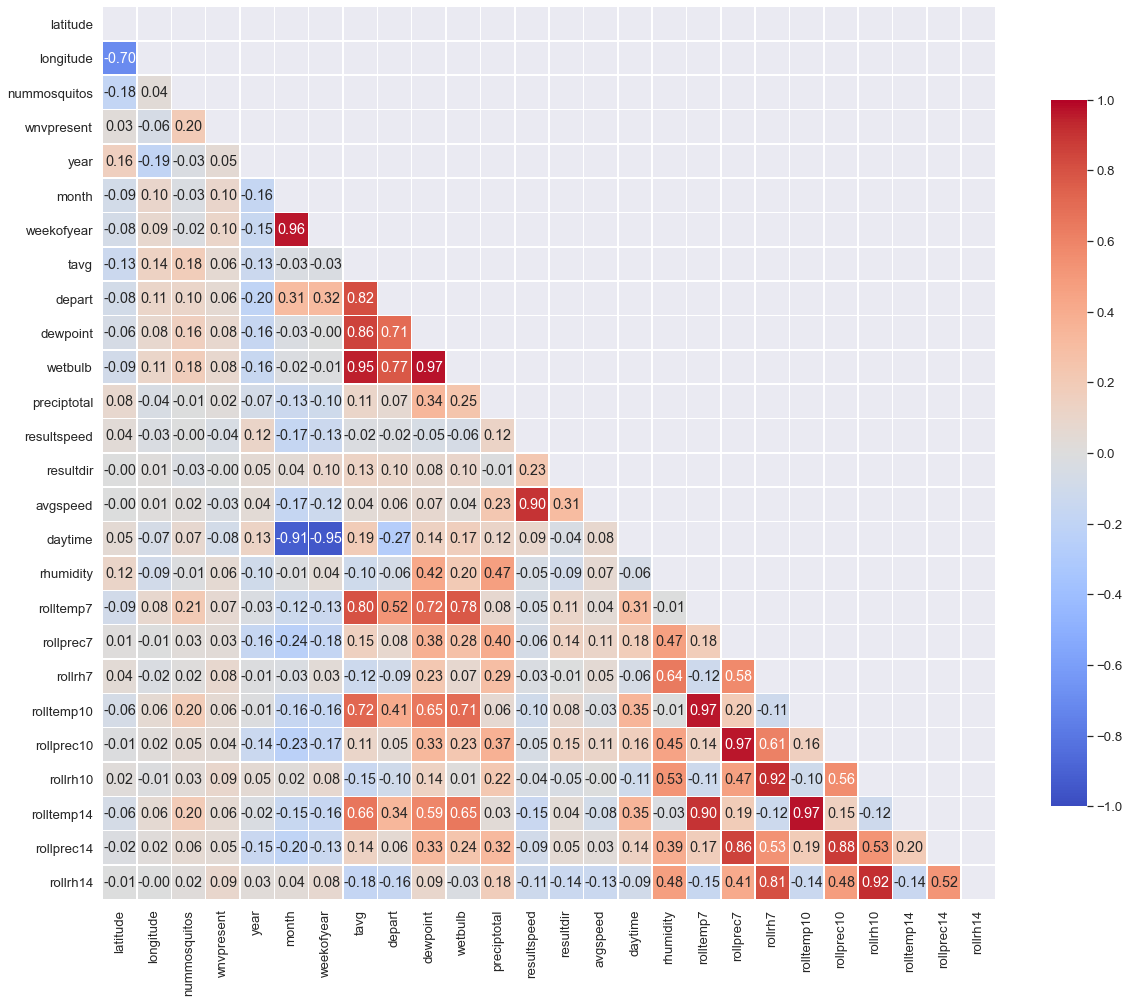

In [75]:

#creates the same matrix as df.corr(), and assigns the values to 0
mask = np.zeros_like(trw_corr.corr())
#setting the upper triangle of the matrix mask to True (which is 1)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,20))
sns.set(font_scale=1.2)
sns.heatmap(trw_corr.corr(), mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True, linewidths=0.5, fmt=".2f",
            cbar_kws={"shrink": .65,  "ticks":np.arange(-1, 1+1, 0.2)}, 
            annot = True)

<font color='blue'> There are a couple of high multicolinear data. Will drop the ones which have lesser correlation with the target data

### Finding multicolinarity in data

In [76]:
#defining a function to put the co-related features into a list to be drop
def findcorrelated(df, target_feature, features, threshold, featurestodrop=True):

    """
    Finds correlated features within the threshold 
    Compares with the correlation value with the target variable.
    returns the features that has lower correlation with the target if featurestodrop=True, 
    else return the high correlated features
    
    Takes in the following arguements:
    df - the dataframe of data
    target_feature - the target feature to find the correlation with
    features - list of features to check
    threshold - the threshold value of the relation between 2 features
    featurestodrop - =True

          
    returns: list of features to that are either high correlated to the target var, 
    or high in relation between 2 feature and is of lower relation to target
    """
    correlation = df.corr()[target_feature]
    covariance = df[features].corr()

    listOfFeatures = [i for i in covariance]
    setOfDroppedFeatures = set() 
    
    if featurestodrop:
    
        #loop all features in the correlation:
        for i in range(len(listOfFeatures)) :
    
            #comparing with everyother feature on the same list
            for j in range(i+1,len(listOfFeatures)): #Avoid repetitions
        
                feature1=listOfFeatures[i]
                feature2=listOfFeatures[j]
        
                #If the correlation between the features is > threshold
                if abs(covariance[feature1][feature2]) > threshold:
            
                    #check which feature has a higher correlation with sales price, drop the lower feature
                    if correlation[feature1] < correlation[feature2]:
                        setOfDroppedFeatures.add(feature1) #Add the smaller one to the list
                    else:
                        setOfDroppedFeatures.add(feature2) #Add the smaller one to the list
    else:
        
        setOfDroppedFeatures = df_corr[abs(correlation)>threshold].index.values
    
    return setOfDroppedFeatures

In [77]:
colinearfeatures = findcorrelated(trw_corr, target_feature='wnvpresent', features=trw_corr.columns, threshold=0.7, featurestodrop=True)
df_colinearfeatures = pd.DataFrame(colinearfeatures, columns=['colinear_features'])

<font color= 'blue'> # Need to comment what's happening

## Test Data Cleaning and Processing

In [78]:
test = pd.read_csv('https://raw.githubusercontent.com/zixinlee/GA-data-science/master/West-nile-virus/data/test.csv')

In [79]:
basic_eda(test, df_name='test.csv DETAILS')

TEST.CSV DETAILS
**********************************************
Rows: 116293 	 Columns: 11

test.csv DETAILS.info()
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int6

**Observations**
- 11 features
- 116293 observations 
- 5 numerical data (ID, Block, Latitude, Longtitude, AddressAccuracy)
- 6 object data (Date, Address, Species, Street, Trap,  AddressNumberAndStreet)
- to change date to datetime type
- no Null values observed
- There are no duplicated data

In [80]:
test.columns = test.columns.str.lower()

# convert `date` to datetime datatype
test['date'] = pd.to_datetime(test['date'])

# create new datetime element columns
test['year'] = test.date.dt.year
test['month'] = test.date.dt.month
test['weekofyear'] = test.date.dt.weekofyear
#test['yearmonth'] = test['year'].apply(str) + '-' + test['month'].apply(str) # ZX: not sure if relevant 
#ensure the months are in 05, 06 format
test['yearmonth'] = test['date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
test['weekday'] = test['date'].dt.weekday

test.drop(columns=['address', 'block', 'street', 'addressnumberandstreet', 'addressaccuracy'], inplace=True)

test['coords'] = list(zip(test['latitude'], test['longitude']))
# create function to find the closer weather station from each trap
# apply the function and create the `closest_station` column
test['closest_station'] = test['coords'].apply(closest_dist)

test.drop(columns='coords', inplace=True)

#Combine weather and test
test_weather = pd.merge(test, weather, left_on=['date', 'closest_station'], right_on=['date', 'station'], how="left")


C:\Users\Rachel\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


In [81]:
test.head()

,id,date,species,trap,latitude,longitude,year,month,weekofyear,yearmonth,weekday,closest_station
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,2008,6,24,2008-06,2,1
1,2,2008-06-11,CULEX RESTUANS,T002,41.955,-87.801,2008,6,24,2008-06,2,1
2,3,2008-06-11,CULEX PIPIENS,T002,41.955,-87.801,2008,6,24,2008-06,2,1
3,4,2008-06-11,CULEX SALINARIUS,T002,41.955,-87.801,2008,6,24,2008-06,2,1
4,5,2008-06-11,CULEX TERRITANS,T002,41.955,-87.801,2008,6,24,2008-06,2,1


In [82]:
test_weather.head()

,id,date,species,trap,latitude,longitude,year,month,weekofyear,yearmonth,weekday,closest_station,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,preciptotal,resultspeed,resultdir,avgspeed,daytime,rhumidity,rolltemp7,rollprec7,rollrh7,rolltemp10,rollprec10,rollrh10,rolltemp14,rollprec14,rollrh14
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,2008,6,24,2008-06,2,1,1,86,61,73.500,7,56,64,0.000,8.900,18,10.000,910,54.310,71.714,0.416,71.893,73.650,0.312,73.447,74.036,0.286,73.940
1,2,2008-06-11,CULEX RESTUANS,T002,41.955,-87.801,2008,6,24,2008-06,2,1,1,86,61,73.500,7,56,64,0.000,8.900,18,10.000,910,54.310,71.714,0.416,71.893,73.650,0.312,73.447,74.036,0.286,73.940
2,3,2008-06-11,CULEX PIPIENS,T002,41.955,-87.801,2008,6,24,2008-06,2,1,1,86,61,73.500,7,56,64,0.000,8.900,18,10.000,910,54.310,71.714,0.416,71.893,73.650,0.312,73.447,74.036,0.286,73.940
3,4,2008-06-11,CULEX SALINARIUS,T002,41.955,-87.801,2008,6,24,2008-06,2,1,1,86,61,73.500,7,56,64,0.000,8.900,18,10.000,910,54.310,71.714,0.416,71.893,73.650,0.312,73.447,74.036,0.286,73.940
4,5,2008-06-11,CULEX TERRITANS,T002,41.955,-87.801,2008,6,24,2008-06,2,1,1,86,61,73.500,7,56,64,0.000,8.900,18,10.000,910,54.310,71.714,0.416,71.893,73.650,0.312,73.447,74.036,0.286,73.940


In [86]:
test['species'].value_counts(normalize=True)

CULEX PIPIENS/RESTUANS   0.132
CULEX RESTUANS           0.126
CULEX PIPIENS            0.125
CULEX SALINARIUS         0.123
CULEX TERRITANS          0.123
CULEX TARSALIS           0.123
UNSPECIFIED CULEX        0.123
CULEX ERRATICUS          0.123
Name: species, dtype: float64

<font color=blue>
There are 2 more new species in test data compared to train data
Test data have a more balanced mosquito spread than our training data

In [90]:
test['trap'].nunique()

149

<font color=blue>
There are 13 more new traps in test data compared to train data. 

## Saving processed data to train and test set

In [83]:
#do a quick check before saving into csv
basic_eda(train_weather, 'Train_weather.csv')

TRAIN_WEATHER.CSV
**********************************************
Rows: 10506 	 Columns: 35

Train_weather.csv.info()
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             10506 non-null  datetime64[ns]
 1   species          10506 non-null  object        
 2   trap             10506 non-null  object        
 3   latitude         10506 non-null  float64       
 4   longitude        10506 non-null  float64       
 5   nummosquitos     10506 non-null  int64         
 6   wnvpresent       10506 non-null  int64         
 7   year             10506 non-null  int64         
 8   month            10506 non-null  int64         
 9   weekofyear       10506 non-null  int64         
 10  yearmonth        10506 non-null  object        
 11  weekday          10506 non-null  

In [84]:
basic_eda(test_weather, 'test_weather.csv')

TEST_WEATHER.CSV
**********************************************
Rows: 116293 	 Columns: 34

test_weather.csv.info()
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 34 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               116293 non-null  int64         
 1   date             116293 non-null  datetime64[ns]
 2   species          116293 non-null  object        
 3   trap             116293 non-null  object        
 4   latitude         116293 non-null  float64       
 5   longitude        116293 non-null  float64       
 6   year             116293 non-null  int64         
 7   month            116293 non-null  int64         
 8   weekofyear       116293 non-null  int64         
 9   yearmonth        116293 non-null  object        
 10  weekday          116293 non-null  int64         
 11  closest_station  11

In [85]:
#savig to csv files
train_weather.to_csv('datasets/train_weather.csv',index=False)
test_weather.to_csv('datasets/test_weather.csv',index=False)
df_colinearfeatures.to_csv('datasets/colinearfeatures.csv',index=False)